# Cleaned vs Dirty v.2

Notebook for the Kaggle Competition:
[Cleaned vs Dirty V2](https://www.kaggle.com/c/platesv2)

```
    @misc{platesv2,
        author = {Igor.Slinko},
        title = {Cleaned vs Dirty V2},
        publisher = {Kaggle},
        year = {2019},
        url = {https://kaggle.com/competitions/platesv2}
    }
```

## Description

It is boring to wash the dishes. Fortunately, some of dishes have been already cleaned. Train a classifier to identify clean ones to save time for a new machine learning course ;)

This is is a few shot learning competition. We have a dataset of **only** 20 cleaned and 20 dirty plates in the train (this is a prerequisite for the competition) and hundreds of plates in the test.

## Image classification with DINOv2

To solve this problem, we will use the SOTA model — **DINOv2**. For details, see the paper: **[DINOv2: Learning Robust Visual Features without Supervision](https://arxiv.org/abs/2304.07193)**

```
  @misc{oquab2023dinov2,
    title={DINOv2: Learning Robust Visual Features without Supervision},
    author={Oquab, Maxime and Darcet, Timothée and Moutakanni, Theo and Vo, Huy V. and Szafraniec, Marc and Khalidov, Vasil
            and Fernandez, Pierre and Haziza, Daniel and Massa, Francisco and El-Nouby, Alaaeldin and Howes, Russell
            and Huang, Po-Yao and Xu, Hu and Sharma, Vasu and Li, Shang-Wen and Galuba, Wojciech and Rabbat, Mike 
            and Assran, Mido and Ballas, Nicolas and Synnaeve, Gabriel and Misra, Ishan and Jegou, Herve and Mairal, Julien 
            and Labatut, Patrick and Joulin, Armand and Bojanowski, Piotr},
    journal={arXiv:2304.07193},
    year={2023}
  }
```


In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import copy
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import shutil 
from tqdm import tqdm

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models as torchvision_models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [3]:
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.1.0
torchvision version: 0.16.0


To run this notebook we need `torchvision` version >= 0.15 (for `transforms.v2`)

In [4]:
def fix_random_seeds(seed=12345):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
fix_random_seeds()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device count = {torch.cuda.device_count()}') 
print(f'Device: {device}')

Device count = 0
Device: cpu


### Preparing the file structure

In [6]:
IS_KAGGLE_ENV = False   # False when local environment
DATA_ROOT, NUM_WORKERS = ('/kaggle/working/plates', 4) if IS_KAGGLE_ENV else ('../data/plates', 0)
OUTPUT_DIR = 'output'

In [7]:
def create_dir_structure(is_kaggle=IS_KAGGLE_ENV):
    if is_kaggle:
        if not os.path.exists(DATA_ROOT):
            # Input data files are available in the "/kaggle/input/" directory.
            with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
                # Extract all the contents of zip file in current directory
                zip_obj.extractall()
            
            indexes = np.random.choice(20, size=4, replace=False)
            file_names = [f'{idx:04}.jpg' for idx in indexes]
            print('Moving files from train to val dir:', file_names)
            
            val_path = os.path.join(DATA_ROOT, 'val')
            os.makedirs(val_path)
            train_path = os.path.join(DATA_ROOT, 'train')
            class_names = ['cleaned', 'dirty']
            for class_name in class_names:
                dest_val_dir  = os.path.join(val_path, class_name)
                src_train_dir = os.path.join(train_path, class_name)
                os.makedirs(dest_val_dir)
                for file_name in file_names:
                    shutil.move(os.path.join(src_train_dir, file_name), dest_val_dir)
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
create_dir_structure()

### Creating models for feature extraction

In [8]:
# class for DINOv2
class ModelWithIntermediateLayers(nn.Module):
    def __init__(self, feature_model, n_last_blocks):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.n_last_blocks = n_last_blocks

    def forward(self, images):
        with torch.inference_mode():
            features = self.feature_model.get_intermediate_layers(
                images, self.n_last_blocks, return_class_token=True
            )
        return features

In [9]:
# class for other models
class ModelWithFeatureExtractor(nn.Module):
    def __init__(self, feature_model, feature_layer):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.feature_extractor = create_feature_extractor(self.feature_model, return_nodes={feature_layer: 'out'})
        inp = torch.randn(1, 3, 224, 224)
        # dry run to get a shape of the output
        with torch.no_grad():
            outp = self.feature_extractor(inp)
        self.embed_dim = outp["out"].size(-1)

    def forward(self, images):
        with torch.no_grad():
            features = self.feature_extractor(images)
        return features['out']

### Section for model configuration

To get features from **DINOv2**:
* we concatenate `CLS` tokens for the `n` last blocks (`use_n_blocks` parameter),
* and (if `use_avgpool` is set to `True`) concatenate the global average pooled features to the `CLS` token.

As an alternative to **DINOv2**, you can use a backbone model from the collection of `torchvision.models`. In this case to get features from the model we use `create_feature_extractor` from `torchvision.models.feature_extraction`. To determine the right layer for feature extraction you can inspect the model with `get_graph_node_names`.

As an alternative option in this example we use `resnet50`.

In [10]:
BACKBONE = 'dinov2' # in ('dinov2', 'resnet50')

BATCH_SIZE = 8
VAL_FREQ = 1
THRESHOLD_FOR_CLEANED = 0.3

model_configurator = {
    'dinov2': {
        'backbone_name': 'dinov2',
        'arch'         : 'large', # in ("small", "base", "large" or "giant")
        'use_n_blocks' : 1,
        'use_avgpool'  : True,
        'init_lr'      : 0.0002,
        'epochs'       : 20,
    },
    'resnet50': {
        'backbone_name': 'resnet50',
        'weights': ResNet50_Weights.IMAGENET1K_V2,
        'feature': 'flatten', # Specify here the layer from where to extract features
        'init_lr': 0.01,
        'epochs' : 30,
    },
}

In [11]:
model_config = model_configurator[BACKBONE]

if BACKBONE == 'dinov2':
    backbone_archs = {
        'small': 'vits14',
        'base': 'vitb14',
        'large': 'vitl14',
        'giant': 'vitg14',
    }
    backbone_arch = backbone_archs[model_config['arch']]
    backbone_name = f'dinov2_{backbone_arch}'
    backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=backbone_name)
    feature_model = ModelWithIntermediateLayers(backbone_model, n_last_blocks=model_config['use_n_blocks'])
    embed_dim = backbone_model.embed_dim * (model_config['use_n_blocks'] + int(model_config['use_avgpool']))
else:
    backbone_model = torchvision_models.get_model(model_config['backbone_name'], weights=model_config['weights'])
    feature_model = ModelWithFeatureExtractor(backbone_model, model_config['feature'])
    embed_dim = feature_model.embed_dim
    
feature_model = feature_model.to(device)


Using cache found in /Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


### Creating a linear classifier

In [12]:
def create_linear_input(x_tokens_list, use_n_blocks, use_avgpool):
    intermediate_output = x_tokens_list[-use_n_blocks:]
    output = torch.cat([class_token for _, class_token in intermediate_output], dim=-1)
    if use_avgpool:
        output = torch.cat(
            (
                output,
                torch.mean(intermediate_output[-1][0], dim=1),  # patch tokens
            ),
            dim=-1,
        )
        output = output.reshape(output.shape[0], -1)
    return output.float()

In [13]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""

    def __init__(self, out_dim, config, num_classes=2):
        super().__init__()
        self.out_dim = out_dim
        if config['backbone_name'] == 'dinov2':
            self.use_dinov2 = True
            self.use_n_blocks = config['use_n_blocks']
            self.use_avgpool = config['use_avgpool']
        else:
            self.use_dinov2 = False
        self.num_classes = num_classes
        self.linear = nn.Linear(out_dim, num_classes)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, input):
        if self.use_dinov2:
            output = create_linear_input(input, self.use_n_blocks, self.use_avgpool)
            return self.linear(output)
        else:
            return self.linear(input)
        
linear_classifier = LinearClassifier(embed_dim, model_config)
linear_classifier = linear_classifier.to(device)

### Defining datasets and dataloaders

In [14]:
# Class for test dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path: Path, tfms: v2.Compose):
        self.path = path
        self.tfms = tfms
        self.filenames = list(path.glob("*.jpg"))
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        img = read_image(str(filename))
        img = self.tfms(img)
        return img, filename.stem
        
    def __len__(self):
        return len(self.filenames)

In [15]:
# INTERPOLATION = v2.InterpolationMode.BICUBIC if BACKBONE == 'dinov2' else v2.InterpolationMode.BILINEAR
CROP_SIZE = 182

In [16]:
data_transforms = {
    'train': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'val': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'test': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Data loaded with {dataset_sizes['train']} train and {dataset_sizes['val']} val images.")

Data loaded with 32 train and 8 val images.


In [17]:
image_datasets['test'] = CustomDataset(Path(os.path.join(DATA_ROOT, 'test')), data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

dataset_sizes['test'] = len(image_datasets['test'])
print(f"Data loaded with {dataset_sizes['test']} test images.")

Data loaded with 744 test images.


### Visualization of examples

In [18]:
def show_batch(imgs, titles=None, rows=2, cols=4):
    if titles is None:
        titles = [ 'image ' + str(i+1) for i in range(imgs.size(0))]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig = plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(imgs.size(0)):
        img = imgs[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    fig.tight_layout()

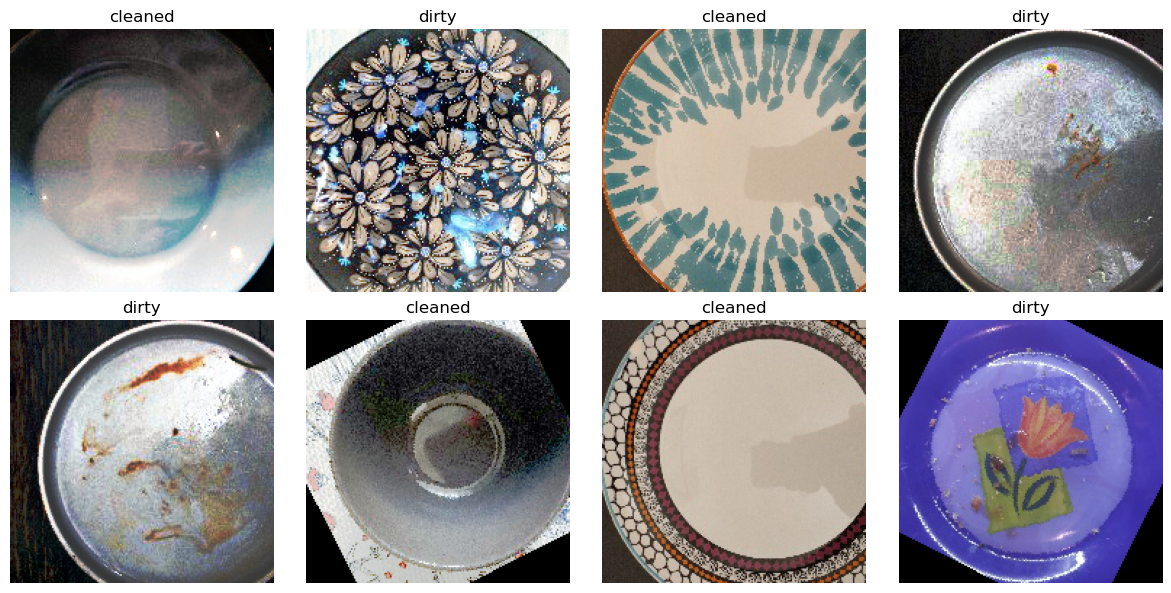

In [19]:
inputs, classes = next(iter(dataloaders['train']))
show_batch(inputs, titles=[class_names[x] for x in classes])

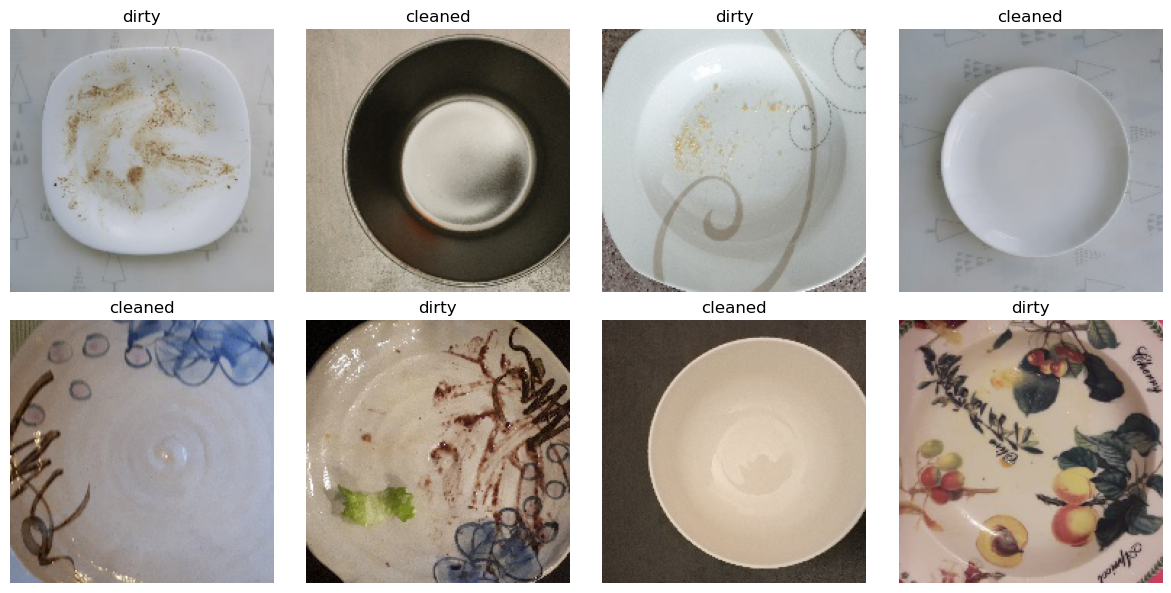

In [20]:
inputs, classes = next(iter(dataloaders['val']))
show_batch(inputs, titles=[class_names[x] for x in classes])

### Train and validation loops

In [21]:
def train_loop(dataloader, feature_model, linear_classifier, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss = 0.0
    running_corrects = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        features = feature_model(X)
        # Compute prediction and loss
        pred = linear_classifier(features)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Statistics
        running_loss += loss.item()
        running_corrects += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_loss = running_loss / num_batches
    epoch_acc  = running_corrects / size
    return epoch_acc, epoch_loss

In [22]:
@torch.inference_mode()
def val_loop(dataloader, feature_model, linear_classifier, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_acc = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)   
            features = feature_model(X) 
            pred = linear_classifier(features)
            val_loss += loss_fn(pred, y).item()
            val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acc  /= size
    return val_acc, val_loss

### Loss function, optimizer, scheduler

In [23]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(
#     linear_classifier.parameters(), 
#     lr=model_config['init_lr'], 
#     betas=(0.9, 0.999)
# )
optimizer = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=model_config['init_lr'],
    momentum=0.9,
    weight_decay=0, # we do not apply weight decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, model_config['epochs'], eta_min=0)


### Main run

In [24]:
best_acc = 0.0
best_acc_loss = np.inf
train_data = []
for t in range(model_config['epochs']):
    print(f'Epoch {t+1}\n-------------------------------')

    train_acc, train_loss = train_loop(dataloaders['train'], feature_model, linear_classifier, loss_fn, optimizer)
    train_data.append({
        'phase': 'train',
        'epoch': t,
        'lr': optimizer.param_groups[0]["lr"],
        'accuracy': train_acc,
        'loss': train_loss
    })
    scheduler.step()
    print(f'Train:\n  train_acc = {train_acc}, train_loss = {train_loss}')
    if t % VAL_FREQ == 0 or t == model_config['epochs'] - 1:
        val_acc, val_loss = val_loop(dataloaders['val'], feature_model, linear_classifier, loss_fn)
        train_data.append({
            'phase': 'val',
            'epoch': t,
            'lr': optimizer.param_groups[0]["lr"],
            'accuracy': val_acc,
            'loss': val_loss
        })
        print(f'Validation:\n    val_acc = {val_acc}, val_loss = {val_loss}')
        if (val_acc == best_acc and val_loss < best_acc_loss) or (val_acc > best_acc):
            best_acc, best_acc_loss = val_acc, val_loss
            print(f'Best accuracy = {best_acc}, best_loss = {best_acc_loss}')
            save_dict = {
                'epoch': t + 1,
                'state_dict': linear_classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                'best_acc': best_acc,
                'best_loss': best_acc_loss
            }
            torch.save(save_dict, os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))

    print('\n')
print('Training completed.')



Epoch 1
-------------------------------
Train:
  train_acc = 0.53125, train_loss = 0.7188645303249359
Validation:
    val_acc = 0.375, val_loss = 0.7433969974517822
Best accuracy = 0.375, best_loss = 0.7433969974517822


Epoch 2
-------------------------------
Train:
  train_acc = 0.78125, train_loss = 0.5809060037136078
Validation:
    val_acc = 0.625, val_loss = 0.6394860148429871
Best accuracy = 0.625, best_loss = 0.6394860148429871


Epoch 3
-------------------------------
Train:
  train_acc = 0.8125, train_loss = 0.5136285871267319
Validation:
    val_acc = 0.75, val_loss = 0.521073579788208
Best accuracy = 0.75, best_loss = 0.521073579788208


Epoch 4
-------------------------------
Train:
  train_acc = 0.90625, train_loss = 0.36902616918087006
Validation:
    val_acc = 0.875, val_loss = 0.41113024950027466
Best accuracy = 0.875, best_loss = 0.41113024950027466


Epoch 5
-------------------------------
Train:
  train_acc = 0.96875, train_loss = 0.2801566421985626
Validation:
    

### Model information

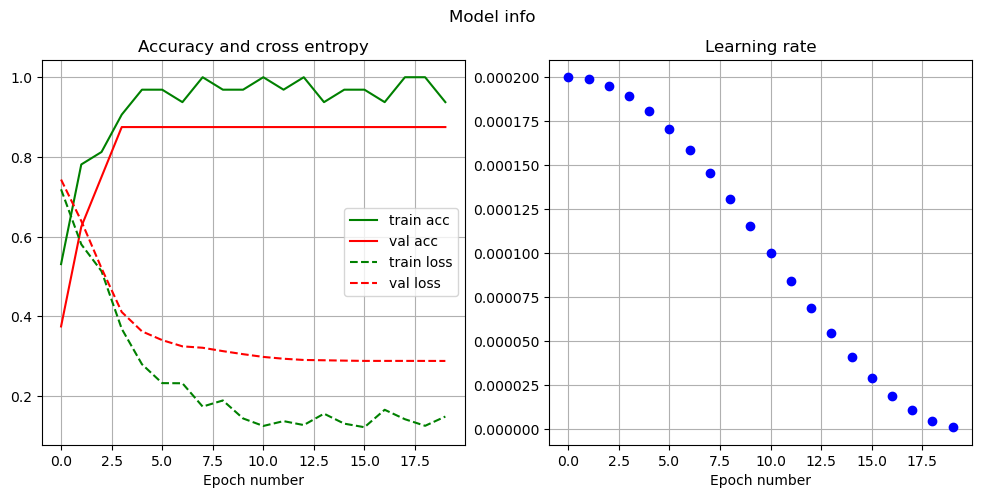

In [25]:
train_df = pd.DataFrame(train_data)
train_phase = train_df[train_df['phase'] == 'train']
val_phase   = train_df[train_df['phase'] == 'val']
y_axis = 'accuracy'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line_acc_train, = ax1.plot(train_phase['epoch'], train_phase['accuracy'], 'g-', label='train acc')
line_acc_val, = ax1.plot(val_phase['epoch'], val_phase['accuracy'], 'r-', label='val acc')
line_loss_train, = ax1.plot(train_phase['epoch'], train_phase['loss'], 'g--', label='train loss')
line_loss_val, = ax1.plot(val_phase['epoch'], val_phase['loss'], 'r--', label='val loss')
ax1.set_xlabel('Epoch number')
ax1.legend(loc='center right')
ax1.set_title('Accuracy and cross entropy')
ax1.grid(visible=True)
line_lr = ax2.plot(train_phase['epoch'], train_phase['lr'], 'ob', label='learning rate')
ax2.set_xlabel('Epoch number')
ax2.set_title('Learning rate')
ax2.grid(visible=True)
fig.suptitle('Model info')
plt.show();

### Inference

#### Restoring from checkpoint

In [26]:
checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))
epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
best_loss = checkpoint['best_loss']
print(f'Best result (validation): epoch:{epoch}, accuracy{best_acc}, cross entropy: {best_loss}')

Best result (validation): epoch:20, accuracy0.875, cross entropy: 0.2884788513183594


In [27]:
model_inf = LinearClassifier(embed_dim, model_config)
model_inf = model_inf.to(device)

model_inf.load_state_dict(checkpoint['state_dict'])
model_inf.eval()


LinearClassifier(
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)

### Visualization of predictions

In [28]:
def visualize_model(feature_model, linear_classifier, images, rows=2, cols=4):
  was_training = linear_classifier.training
  linear_classifier.eval()

  with torch.no_grad():
    imgs = images.to(device)
    features = feature_model(imgs)
    outputs = linear_classifier(features)
    outputs = nn.functional.softmax(outputs, dim=1)
    prediction_score, pred_label_idx = torch.topk(outputs, 1)
    _, preds = torch.max(outputs, 1)
    # titles = [f'{class_names[pred_label_idx[i]]}: score {prediction_score[i].squeeze().item():.3f}' for i in range(imgs.size(0))]
    titles = [f'Clean:{outputs[i, 0].squeeze().item():.3f}; Dirty:{outputs[i, 1].squeeze().item():.3f}' for i in range(imgs.size(0))]
    show_batch(imgs, titles=titles)
    
  linear_classifier.train(mode=was_training)


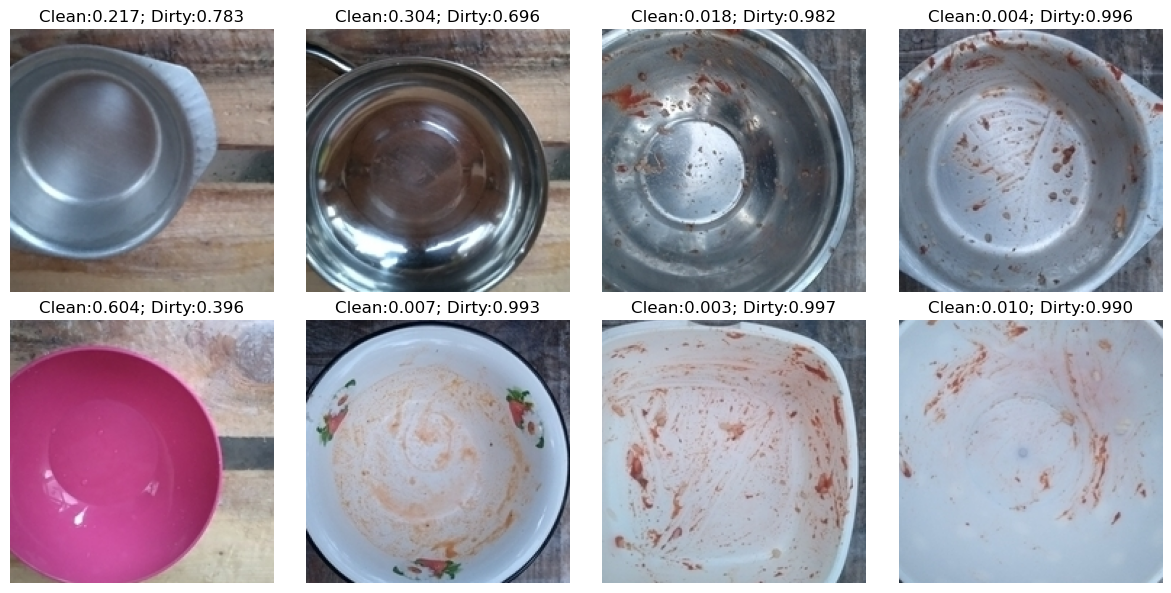

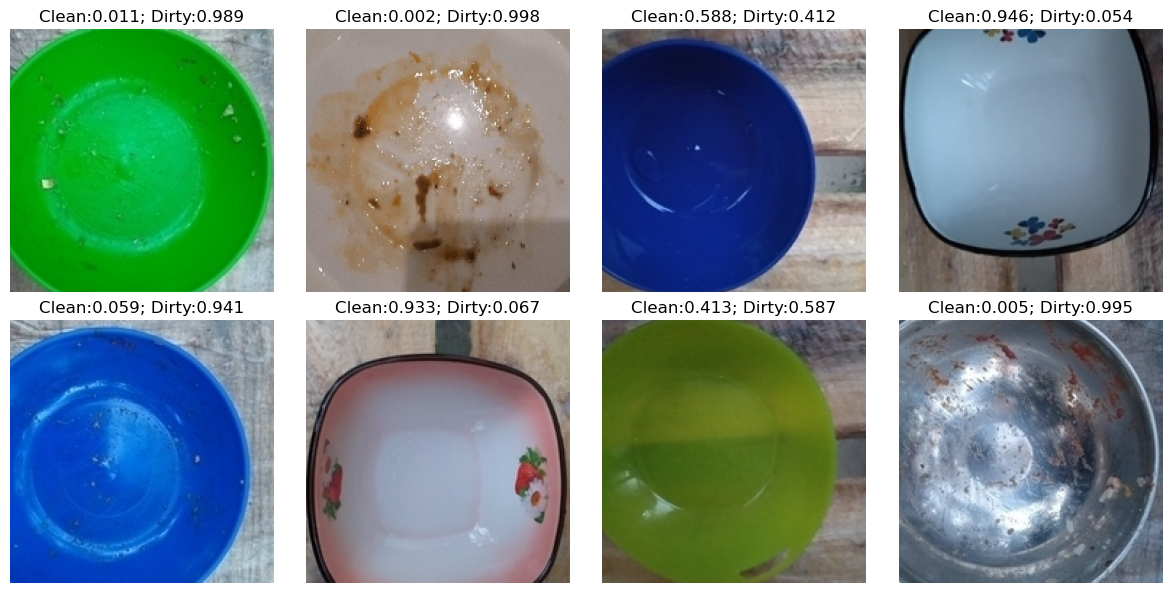

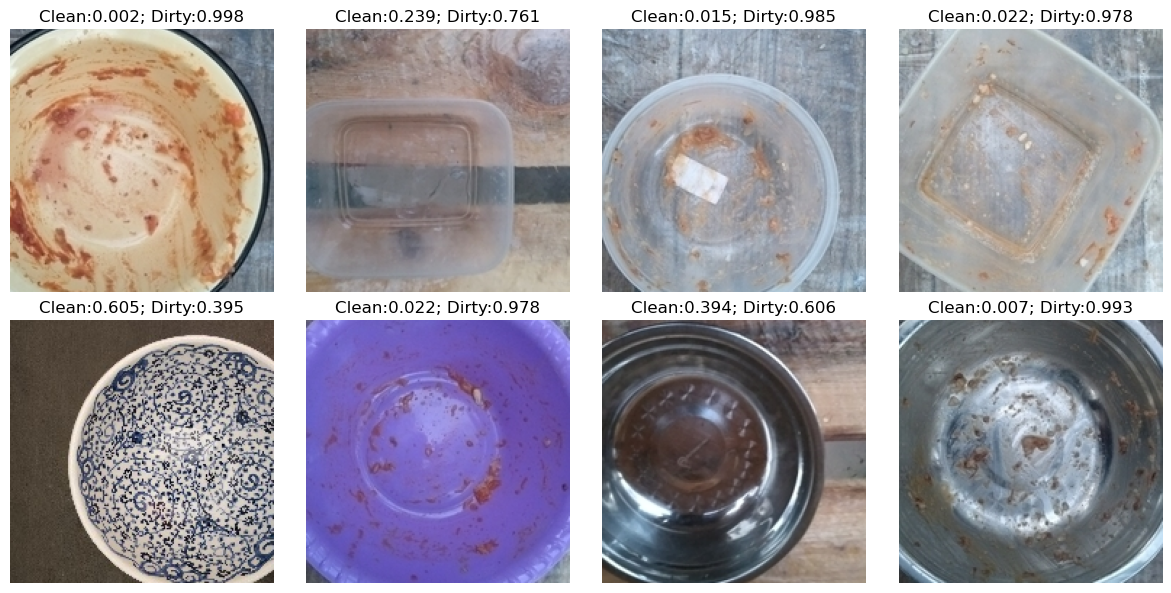

In [29]:
dl_iter = iter(dataloaders['test'])
for _ in range(3):
    imgs, _ = next(dl_iter)
    visualize_model(feature_model, model_inf, imgs)

### Submitting predictions

In [30]:
test_predictions = []
test_img_paths = []
for inputs, paths in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        features = feature_model(inputs)
        preds = model_inf(features)
    test_predictions.append(
        nn.functional.softmax(preds, dim=1)[:,0].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [06:24<00:00,  4.13s/it]


In [31]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'cleaned' if pred >= THRESHOLD_FOR_CLEANED else 'dirty')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(10)

label
id           
0071    dirty
0717  cleaned
0703    dirty
0065    dirty
0059  cleaned
0515    dirty
0273    dirty
0267    dirty
0501    dirty
0529    dirty

In [32]:
submission_df.to_csv('submission.csv')